In [1]:
import pandas as pd
import numpy as np
import numpy.typing as npt
from datetime import datetime

import yfinance as yf
from utility.types import AllocationMethodsEnum

from data.benchmark import Benchmark
from data.universe import Universe
from backtest.backtest import Backtester

In [2]:
bench = Benchmark()
bench.get_benchmark_history()

[*********************100%%**********************]  1 of 1 completed


Date
1987-09-10     168.970001
1987-09-11     170.539993
1987-09-14     170.429993
1987-09-15     169.199997
1987-09-16     168.919998
                 ...     
2024-03-11    2065.879883
2024-03-12    2065.479980
2024-03-13    2071.709961
2024-03-14    2031.180054
2024-03-15    2039.319946
Freq: B, Name: ^RUT, Length: 9527, dtype: float64

In [3]:
univ = Universe()
df = univ.get_universe_history()

[*********************100%%**********************]  10 of 10 completed


In [4]:
from typing import Dict, List  # MMM->APPL->AMZN | MSFT->AFL | BSX -> IP

from utility.types import SpinOff


spin_off_announcement: Dict[datetime, List[SpinOff]] = {
    datetime(2015, 12, 10): [
        SpinOff(
            parent_company="AMZN",
            subsidiary_company="MMM",
            spin_off_ex_date=datetime(2015, 12, 15),
        )
    ],
    datetime(2005, 10, 14): [
        SpinOff(
            parent_company="MSFT",
            subsidiary_company="AFL",
            spin_off_ex_date=datetime(2005, 10, 17),
        ),
        SpinOff(
            parent_company="AAPL",
            subsidiary_company="AMZN",
            spin_off_ex_date=datetime(2005, 10, 18),
        ),
    ],
    datetime(2008, 2, 15): [
        SpinOff(
            parent_company="BSX",
            subsidiary_company="IP",
            spin_off_ex_date=datetime(2008, 2, 18),
        ),
        SpinOff(
            parent_company="BSX",
            subsidiary_company="MC.PA",
            spin_off_ex_date=datetime(2008, 2, 18),
        ),
    ],
}

spin_off_announcement

{datetime.datetime(2015, 12, 10, 0, 0): [SpinOff(parent_company='AMZN', subsidiary_company='MMM', spin_off_ex_date=datetime.datetime(2015, 12, 15, 0, 0))],
 datetime.datetime(2005, 10, 14, 0, 0): [SpinOff(parent_company='MSFT', subsidiary_company='AFL', spin_off_ex_date=datetime.datetime(2005, 10, 17, 0, 0)),
  SpinOff(parent_company='AAPL', subsidiary_company='AMZN', spin_off_ex_date=datetime.datetime(2005, 10, 18, 0, 0))],
 datetime.datetime(2008, 2, 15, 0, 0): [SpinOff(parent_company='BSX', subsidiary_company='IP', spin_off_ex_date=datetime.datetime(2008, 2, 18, 0, 0)),
  SpinOff(parent_company='BSX', subsidiary_company='MC.PA', spin_off_ex_date=datetime.datetime(2008, 2, 18, 0, 0))]}

# Analyze parent behavior around spin off


In [5]:
from backtest.analysis import get_spin_off_parent_behavior

DAYS_BEFORE = 50
DAYS_AFTER = 50

behaviours = []

for spinoffs in spin_off_announcement.values():
    for spinoff in spinoffs:
        behaviours.append(
            get_spin_off_parent_behavior(
                univ.get_universe_returns(), spinoff, DAYS_BEFORE, DAYS_AFTER
            )
        )

behaviours = np.array(behaviours)

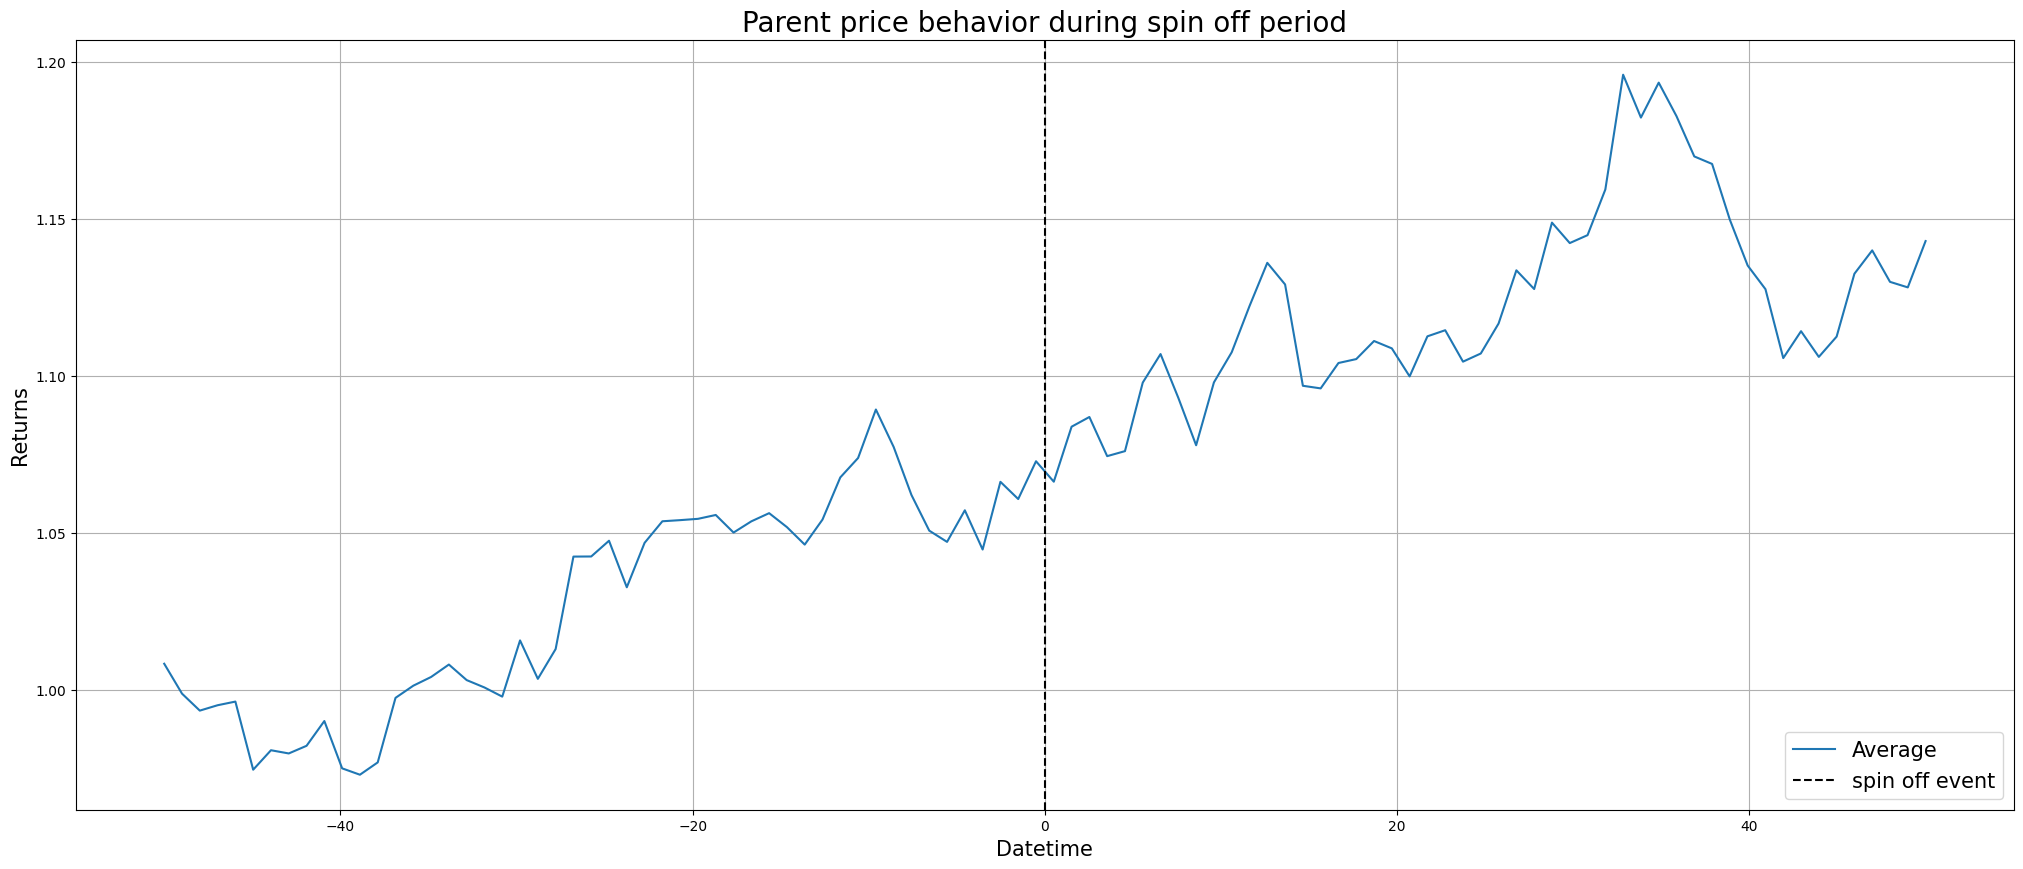

In [11]:
from matplotlib import pyplot as plt
_, ax = plt.subplots(1,1, figsize=(25, 10))

ax.plot(np.linspace(-DAYS_BEFORE,DAYS_AFTER,num=DAYS_BEFORE+DAYS_AFTER),np.mean(behaviours, axis=0),label="Average")
ax.axvline(x=0,color="black",label="spin off event",linestyle='--')
ax.grid()
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Returns", fontsize=15)
ax.set_title(
f"Parent price behavior during spin off period", fontsize=20
)
ax.legend(loc="lower right", fontsize=15)

# Backtest spin off


In [12]:
bk_test = Backtester(
    universe_returns=univ.get_universe_returns(),
    benchmark_returns=bench.get_benchmark_returns(),
)

ptf_and_bench, ptf_weights_df, ptf_metrics_df = bk_test.run_backtest(
    AllocationMethodsEnum.EQUALLY_WEIGHTED,
    spin_off_events_announcement=spin_off_announcement,
    backtest_type="parents",
    holding_period_in_months=15,
    transaction_cost=0.001,  # 10 BP
)

Backtesting portfolio...:  27%|██▋       | 1679/6315 [00:01<00:03, 1317.96it/s]

Rebalancing the portfolio on due to spin off announcement on 2005-10-14 00:00:00...
Rebalancing the portfolio on due to spin off event on 2005-10-17 00:00:00...
Rebalancing the portfolio on due to spin off event on 2005-10-18 00:00:00...


Backtesting portfolio...:  31%|███▏      | 1983/6315 [00:01<00:03, 1291.59it/s]

Rebalancing the portfolio on due to nothing in the portfolio at 2006-12-29 00:00:00... (No more securities in the portfolio)
Rebalancing the portfolio on due to spin off announcement on 2008-02-15 00:00:00...
Rebalancing the portfolio on due to spin off event on 2008-02-18 00:00:00...


Backtesting portfolio...:  42%|████▏     | 2682/6315 [00:02<00:02, 1226.49it/s]

Rebalancing the portfolio on due to nothing in the portfolio at 2009-05-01 00:00:00... (No more securities in the portfolio)


Backtesting portfolio...:  67%|██████▋   | 4235/6315 [00:03<00:01, 1509.94it/s]

Rebalancing the portfolio on due to spin off announcement on 2015-12-10 00:00:00...
Rebalancing the portfolio on due to spin off event on 2015-12-15 00:00:00...


Backtesting portfolio...:  74%|███████▍  | 4668/6315 [00:03<00:01, 1197.89it/s]

Rebalancing the portfolio on due to nothing in the portfolio at 2017-02-23 00:00:00... (No more securities in the portfolio)



-------  Returns statistical information  --------
Expected return annualized: 5.65 % vs 8.51 % (benchmark)
CAGR: 2.22 % vs 5.82 % (benchmark)
Expected volatility annualized: 26.57 % vs 24.10 % (benchmark)
Specific volatility (diversifiable) annualized: 13.84 %
Systematic volatility annualized: 22.68 %
Skewness: 0.28 vs -0.30 (benchmark), <0 = left tail, >0 = right tail
Kurtosis: 18.62 vs -0.30 (benchmark) , >3 = fat tails, <3 = thin tails
95%-VaR: -2.41 % vs -2.35 % (benchmark) -> the lower the better
95%-CVaR: -3.81 % vs -3.50 % (benchmark) -> the lower the better

-------  Strategy statistical information  -------
Max drawdown: -75.12 % vs -59.89 % (benchmark)
Kelly criterion: 2.04 % vs 3.25 % (benchmark)
Benchmark sensitivity (beta): 0.94 vs 1 (benchmark)
Determination coefficient R²: 0.73
Tracking error annualized: 13.91 %

---------------  Strategy ratios  ----------------
No risk free rate considered for the following ratios.

Sharpe ratio annualized: 0.21 vs 0.35 (benchmark)
S